# Housing Prices

Goal: It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.  
Metric: Submissions are evaluated on [Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
from fastai.structured import*
from fastai.imports import*
from sklearn.ensemble import RandomForestRegressor

/home/cho/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
PATH = '/home/cho/fastai/courses/ml1/kaggle/housing prices/'

In [ ]:
pd.set_option('display.max_rows', 1000, 'display.max_columns', 1000)

In [ ]:
def display_all(df):
    with pd.option_context('display.max_columns', 1000, 'display.max_rows', 1000):
        display(df)

In [ ]:
def split_vals(a,n):
    return a[:n].copy(), a[n:].copy()

In [ ]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [ ]:
def print_score(m):
    res = [rmse(m.predict(X_train),y_train), rmse(m.predict(X_valid),y_valid),
          m.score(X_train,y_train), m.score(X_valid,y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
        print(res)

In [ ]:
df_train_raw = pd.read_csv(f'{PATH}/data/train.csv', parse_dates=['YearBuilt','YearRemodAdd','YrSold'])

In [ ]:
df_train_raw.shape

(1460, 81)

In [ ]:
# df_train_raw.info()

In [ ]:
df_test_raw = pd.read_csv(f'{PATH}/data/test.csv')

In [ ]:
df_test_raw.shape

(1459, 80)

Compare columns that are in training and not in test

In [ ]:
set(df_train_raw) - set(df_test_raw)

{'SalePrice'}

In [ ]:
df_train = df_train_raw.copy()

In [ ]:
train_cats(df_train)

Apply the same categories created in df_train to df_test

In [ ]:
# df_test = df_test_raw.copy()
# apply_cats(df=df_test, trn=df_train)

Note that we are evaluated based on the RMSE between the log of predicted SalePrice and log of observed SalePrice.  
The log below is the natural log, ln x = log e x = y

In [ ]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

In [ ]:
df_trn, y_trn, nas = proc_df(df_train, 'SalePrice')

Let's take 20% of the training set as validation set

In [ ]:
n_valid = int(len(df_train_raw)*0.2)
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_train_raw, n_trn)

### Baseline model

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

### First Kaggle submission

In [ ]:
df_test, _, nas=proc_df(df_test, y_fld=None)

In [ ]:
df_test.shape

In [ ]:
df_trn.shape

There are additional missing rows in the test dataset and proc_df() generated additional _na variables, so they need to be removed

In [ ]:
to_drop = list(set(df_test) - set(df_trn))

In [ ]:
df_test.drop(columns=to_drop, inplace=True)

In [ ]:
df_test_array = df_test.to_numpy()

In [ ]:
preds_log = m.predict(df_test_array)

Converting the natural log of SalePrice predictions to SalePrice

In [ ]:
preds = np.exp(preds_log)

In [ ]:
housing_submission = pd.DataFrame({'Id':df_test_raw['Id'], 'SalePrice':preds})

In [ ]:
housing_submission.to_csv(f'{PATH}/housing_submission_v1.csv', index=False)

### Tuning the parameters

In [1]:
m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

NameError: ignored

### Second Kaggle Submission

In [ ]:
df_test = df_test_raw.copy()
apply_cats(df=df_test, trn=df_train)

In [ ]:
df_test, _, nas = proc_df(df_test, y_fld=None)

In [ ]:
to_drop = list(set(df_test) - set(df_trn))

In [ ]:
df_test.drop(columns=to_drop, inplace=True)

In [ ]:
df_test_array = df_test.to_numpy()

In [ ]:
preds_log = m.predict(df_test_array)

In [ ]:
preds = np.exp(preds_log)

In [ ]:
df_test_raw.head(3)

In [ ]:
housing_submission = pd.DataFrame({'Id':df_test_raw['Id'], 'SalePrice':preds})

In [ ]:
housing_submission.to_csv(f'{PATH}/housing_submission_v2.csv', index=False)

### The Confidence based on tree variance

In [ ]:
preds = np.array([t.predict(X_valid) for t in m.estimators_])

In [ ]:
preds.shape

In [ ]:
np.mean(preds)

In [ ]:
x = raw_valid.copy()

In [ ]:
x['SalePrice'] = np.log(x['SalePrice'])

In [ ]:
x['preds'] = np.mean(preds, axis=0)

In [ ]:
x['preds_std'] = np.std(preds, axis=0)

In [ ]:
x.head()

In [ ]:
x_agg = x.groupby(['MSSubClass']).agg({'Id':'count','SalePrice':'mean','preds':'mean','preds_std':'mean'}).reset_index()
x_agg['ratio'] = x_agg['preds_std']/x_agg['preds']

alt.Chart(x_agg).mark_bar().encode(
    x='ratio:Q',
    y='MSSubClass:N',
    tooltip=['MSSubClass:N','SalePrice:Q','Id','preds_std']
)

In [ ]:
x_agg = x.groupby(['MSZoning'], as_index=False).agg({'Id':'count','SalePrice':'mean','preds':'mean','preds_std':'mean'})
x_agg['ratio'] = x_agg['preds_std']/x_agg['preds']

alt.Chart(x_agg).mark_bar().encode(
    x='ratio:Q',
    y='MSZoning:N',
    tooltip=['MSZoning:N','ratio:Q','preds_std','preds']
)

### Feature Importance

In [ ]:
fi = rf_feat_importance(m, df_trn)

In [ ]:
fi.sort_values(by='imp').plot(x='cols', y='imp', kind='barh', figsize=(10,15), legend=False)

In [ ]:
fi.head(20)

Keep columns which have an importance of at least 0.004

In [ ]:
to_keep = fi.query('imp >= 0.004')['cols']

In [ ]:
df_keep = df_trn[to_keep]

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

We are able to still get the same result if we keep only 25 features based on feature importance

In [ ]:
feats = df_keep.columns

In [ ]:
for f in feats:
    df_subs = df_keep.drop(columns=f)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print('If removed', f)
    print_score(m)

### Remove redundant features with hierarchical clustering

In [ ]:
import scipy.cluster.hierarchy as sch
from scipy import stats

In [ ]:
corr = np.round(stats.spearmanr(df_keep).correlation, 4)

In [ ]:
corr_condensed = sch.distance.squareform(1-corr)

In [ ]:
z = sch.linkage(corr_condensed, method='average')

In [ ]:
fig = plt.figure(figsize=(10,12))
dendrogram = sch.dendrogram(z, labels=df_keep.columns.tolist(), orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
fi.query('imp > 0.004').sort_values(by='imp').plot(kind='barh', x='cols', y='imp', figsize=(10,15), legend=False)

In [ ]:
to_remove = ['LotFrontage', '1stFlrSF', 'FireplaceQu', 'FullBath','GarageYrBlt','GarageArea','CentralAir','KitchenQual','MSZoning','GarageType']

In [ ]:
for f in to_remove:
    df_subs = df_keep.drop(columns=f)
    X_train, X_valid = split_vals(df_keep, n_trn)
    m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print('If removed', f)
    print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

### Third Kaggle Submission

In [ ]:
to_remove = ['LotFrontage','CentralAir']

In [ ]:
df_keep2 = df_keep.drop(columns=to_remove)

In [ ]:
X_train, X_valid = split_vals(df_keep2, n_trn)

In [ ]:
m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
df_test = df_test_raw.copy()
apply_cats(df=df_test, trn=df_train)

In [ ]:
df_test, _, nas = proc_df(df_test, y_fld=None)

In [ ]:
to_drop = list(set(df_test) - set(df_keep2))

In [ ]:
df_test.drop(columns=to_drop, inplace=True)

In [ ]:
df_test_array = df_test.to_numpy()

In [ ]:
preds_log = m.predict(df_test_array)

In [ ]:
preds = np.exp(preds_log)

In [ ]:
housing_submission = pd.DataFrame({'Id':df_test_raw['Id'], 'SalePrice':preds})

In [ ]:
housing_submission.to_csv(f'{PATH}/housing_submission_v3.csv', index=False)

The leaderboard position went down by a lot after the third submission. Second submission is still better.

### One hot encoding

To create a one hot encoding dataset, we cannot have datetime data types in the dataset, hence re-reading the raw data

In [ ]:
df_train_raw = pd.read_csv(f'{PATH}/data/train.csv')

In [ ]:
df_train = df_train_raw.copy()

In [ ]:
train_cats(df_train)

In [ ]:
df_trn2, y_trn, nas=proc_df(df_train, 'SalePrice', max_n_cat=7)

In [ ]:
X_train, X_valid = split_vals(df_trn2, n_trn)

In [ ]:
m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
fi = rf_feat_importance(m, df_trn2)

In [ ]:
fi.query('imp >= 0.005').sort_values(by='imp').plot(kind='barh', x='cols', y='imp', figsize=(12,10), legend=False)

In [ ]:
to_keep = fi.query('imp >= 0.005')['cols']
df_trn2[to_keep].info()

In [ ]:
raw_train['ExterQual'].value_counts()

### The 2nd Submission is still the best

In [ ]:
m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07735353316857367, 0.14410689904163668, 0.9628469458431023, 0.8642353107457545, 0.8719066791039736]


In [ ]:
fi = rf_feat_importance(m, df_trn)

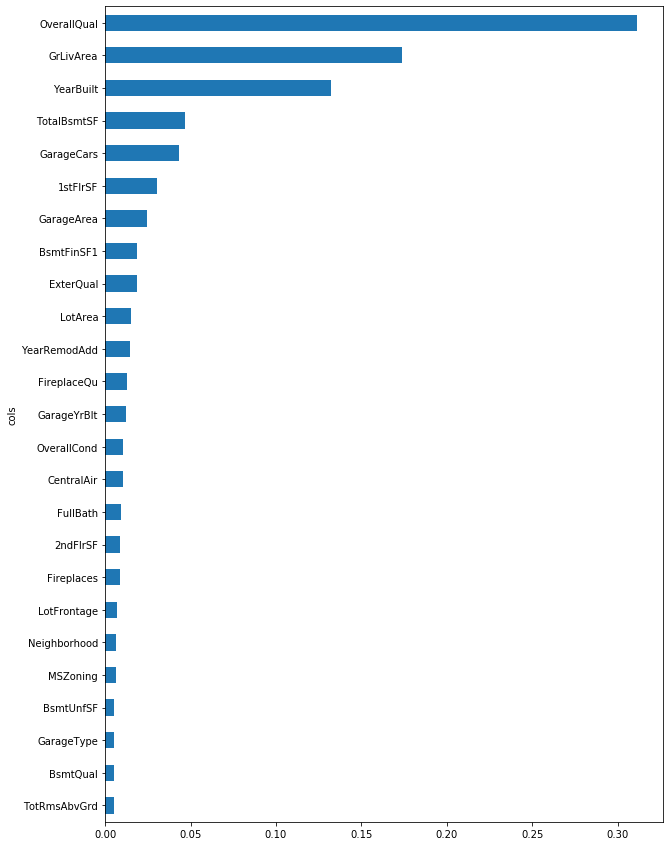

In [ ]:
fi.query('imp >= 0.004').sort_values(by='imp').plot(x='cols', y='imp', kind='barh', figsize=(10,15), legend=False)

#### OverallQual

In [ ]:
raw_train['OverallQual'].describe()

In [ ]:
alt.Chart(raw_train).mark_bar().encode(
    x='OverallQual:O',
    y='count(OverallQual):Q'
)

In [ ]:
alt.Chart(raw_train).mark_boxplot().encode(
    y='SalePrice:Q'
)

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='OverallQual:Q',
    y='SalePrice:Q',
    tooltip=['OverallQual:Q','SalePrice:Q','Id']
)

In [ ]:
alt.Chart(raw_train).mark_boxplot().encode(
    x='OverallQual:Q',
    y='SalePrice:Q',
    tooltip=['OverallQual:Q','SalePrice:Q','Id']
)

### GrLivArea

In [ ]:
alt.Chart(raw_train).mark_bar().encode(
    x=alt.X('GrLivArea', bin=alt.Bin(maxbins=80)),
    y='count(GrLivArea):Q',
)

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='GrLivArea:Q',
    y='SalePrice:Q',
    tooltip=['GrLivArea:Q','SalePrice:Q','Id']
)

### YearBuilt

In [ ]:
alt.Chart(raw_train).mark_line().encode(
    x='YearBuilt:T',
    y='SalePrice:Q',
    tooltip=['YearBuilt:T','SalePrice:Q','Id']
)

### TotalBsmtSF

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='TotalBsmtSF:Q',
    y='SalePrice:Q',
    tooltip=['TotalBsmtSF:Q','SalePrice:Q','Id']
)

### GarageCars

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='GarageCars:O',
    y='SalePrice:Q',
    tooltip=['GarageCars:Q','SalePrice:Q','Id']
)

### 1stFlrSF

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='1stFlrSF:Q',
    y='SalePrice:Q',
    tooltip=['1stFlr:Q','SalePrice:Q','Id']
)

### 2ndFlrSF

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='2ndFlrSF:Q',
    y='SalePrice:Q',
    tooltip=['2ndFlr:Q','SalePrice:Q','Id']
)

### GarageArea

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='GarageArea:Q',
    y='SalePrice:Q',
    tooltip=['GarageArea:Q','SalePrice:Q','Id']
)

### ExterQual

In [ ]:
alt.Chart(raw_train).mark_bar().encode(
    x='ExterQual',
    y='median(SalePrice):Q',
    tooltip=['ExterQual:Q','median(SalePrice):Q']
)

### FullBath

In [ ]:
alt.Chart(raw_train).mark_bar().encode(
    x='FullBath:N',
    y='median(SalePrice):Q',
    tooltip=['FullBath:N','median(SalePrice):Q']
)

### Feature Engineering 

#### Create a TotalSF variable
TotalSF = 1stFlrSF + 2ndFlrSF + TotalBsmtSF  
Using the raw_train below so that we can plot it against the original SalePrice and not the natural log of SalePrice

In [ ]:
raw_train['TotalSF'] = raw_train['1stFlrSF'] +  raw_train['2ndFlrSF'] + raw_train['TotalBsmtSF']

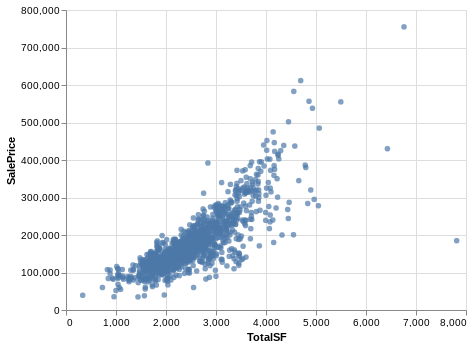

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='TotalSF:Q',
    y='SalePrice:Q',
    tooltip=['TotalSF:Q','SalePrice:Q','Id']
)

#### Create YearDiff variable
YearDiff = YrSold - YearBuilt

In [ ]:
raw_train['YearDiff'] = raw_train['YrSold'].dt.year - raw_train['YearBuilt'].dt.year

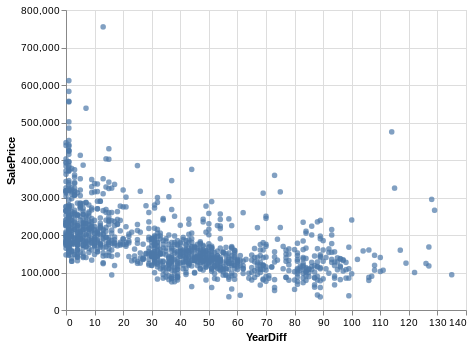

In [ ]:
alt.Chart(raw_train).mark_circle().encode(
    x='YearDiff:Q',
    y='SalePrice:Q',
    tooltip=['YearDiff','SalePrice:Q','Id']
)

Now, we create the new features in the df_train which is the transformed raw_train dataset.

In [ ]:
df_train['TotalSF'] = df_train['1stFlrSF'] +  df_train['2ndFlrSF'] + df_train['TotalBsmtSF']

In [ ]:
df_train['YearDiff'] = df_train['YrSold'].dt.year - df_train['YearBuilt'].dt.year

Removing below outliers discovered above

In [ ]:
outliers_id = [441, 497, 524, 582, 692, 1062]

In [ ]:
df_train2 = df_train.query('Id != @outliers_id')

Removing below features seem to make the score worse, so we will keep them though we have created new features based on a combination of them.

In [ ]:
to_drop = ['1stFlrSF','2ndFlrSF','TotalBsmtSF','YrSold','YearBuilt']

In [ ]:
for feat in to_drop:
    df_sub = df_trn.drop(columns=feat)
    X_train, X_valid = split_vals(df_sub, n_trn)
    m = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print('If removed', feat)
    print_score(m)

If removed 1stFlrSF
[0.07328029435998352, 0.1464077505139591, 0.9660354337441467, 0.8567142159099282, 0.8824549783777453]
If removed 2ndFlrSF
[0.07266308378049013, 0.14872693257325967, 0.9666051641772934, 0.8521388054517277, 0.8840430396681822]
If removed TotalBsmtSF
[0.07368200858208267, 0.14612136354878547, 0.9656620333097307, 0.8572742278823641, 0.886063341318193]
If removed YrSold
[0.07376544656406013, 0.14711768732855965, 0.9655842202065164, 0.8553212502477266, 0.8829106770654165]
If removed YearBuilt
[0.07417461140342374, 0.14823264641806058, 0.9652013639456481, 0.8531199901205844, 0.8826717122829258]


In [ ]:
df_trn, y_trn, na = proc_df(df_train2, 'SalePrice')

In [ ]:
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [ ]:
m = RandomForestRegressor(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07266255646499847, 0.1432288127225444, 0.9666056488677154, 0.8628689654360454, 0.8855046074711875]


In [ ]:
fi2 = rf_feat_importance(m, df_trn)

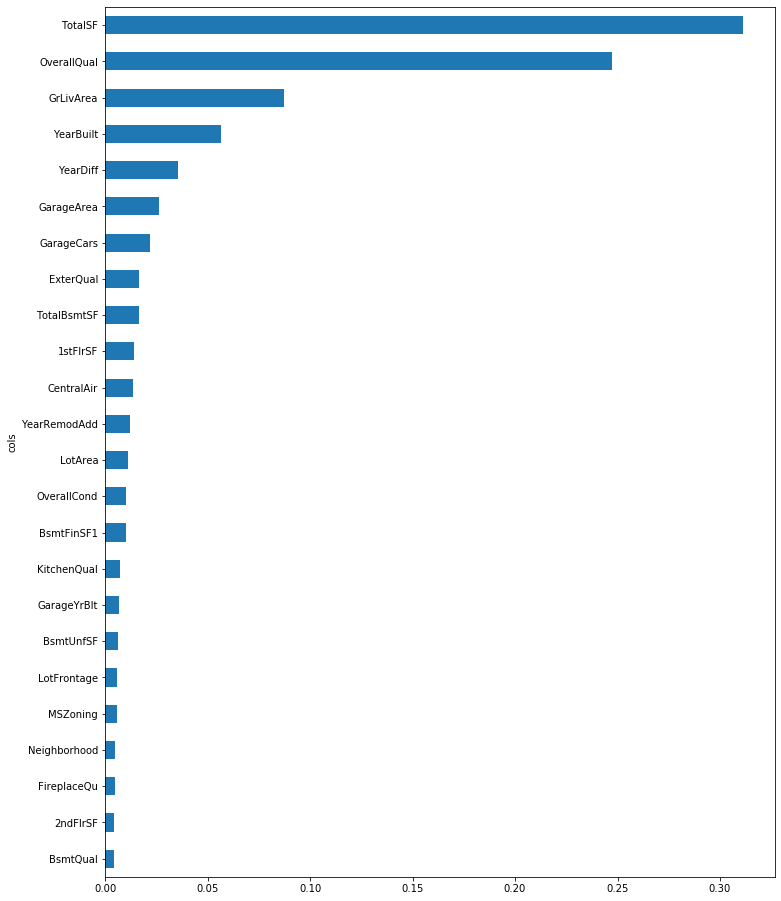

In [ ]:
fi2.query('imp >= 0.004').sort_values(by='imp').plot(kind='barh', x='cols', y='imp', figsize=(12,16), legend=False)

Let's try gridsearch to optimize hyperparameter